# Kaggle Titanic Survivor Predictions

In [1]:
from fastai.tabular import *

## Download data from Kaggle competition page

Step 1: Fetch/download data from Kaggle website. Using instructions from Lesson 3 (copied here for reference).

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add source activate fastai or similar, or prefix pip with a path. Have a look at how conda install is called for your platform in the appropriate Returning to work section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [1]:
# install kaggle apis first
#! pip install kaggle --upgrade

    100% |████████████████████████████████| 61kB 30.1MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 50.8MB/s ta 0:00:01
Requirement not upgraded as not directly required: six>=1.10 in /opt/anaconda3/lib/python3.7/site-packages (from kaggle) (1.11.0)
Requirement not upgraded as not directly required: certifi in /opt/anaconda3/lib/python3.7/site-packages (from kaggle) (2018.11.29)
Requirement not upgraded as not directly required: python-dateutil in /opt/anaconda3/lib/python3.7/site-packages (from kaggle) (2.7.5)
Requirement not upgraded as not directly required: requests in /opt/anaconda3/lib/python3.7/site-packages (from kaggle) (2.19.1)
Requirement not upgraded as not directly required: tqdm in /opt/anaconda3/lib/python3.7/site-packages (from kaggle) (4.26.0)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/anaconda3/lib/python3.7/site-packages (from requests->kaggle) (3.0.4)
Requirement not upgraded as not directly required: idna<2.8

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal).

In [2]:
# double check - have you uploaded the latest/valid API token file to working directory?
# ok then... now setting up credentials
#! mkdir -p ~/.kaggle/
#! mv kaggle.json ~/.kaggle/

You're all set to download the data from [titanic competition](https://www.kaggle.com/c/titanic). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [2]:
#Setup local directory to receive the dataset
path = Config.data_path()/'titanic'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/titanic')

In [6]:
# initiate download of data - replace with appropriate competition string - examples below
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

#! kaggle competitions download -c titanic -f train.csv -p {path}
#! kaggle competitions download -c titanic -f test.csv -p {path}

  0%|                                               | 0.00/59.8k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 59.8k/59.8k [00:00<00:00, 43.2MB/s]
  0%|                                               | 0.00/28.0k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 28.0k/28.0k [00:00<00:00, 21.0MB/s]


If your test data has 7z zip files you will also need to install the 7zip utility. You can do this on command line (sudo apt install p7zip) or run these commands to install and unzip:

In [ ]:
# Note: Run these only if you have 7zip files in the data and need to unpack them
#! conda install -y -c haasad eidl7zip
#! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

## Setup data for analysis and training - Using Pandas

The Python Pandas library allows easy operations on tabular and time series data. It uses a DataFrame object to provide access to and execute operations on the data. First step is to move csv data into a pandas dataframe.

In [3]:
# read in the training data first
traindf = pd.read_csv(path/'train.csv')

In [4]:
# also read in the test data
testdf = pd.read_csv(path/'test.csv')

Print out the train and test df and explore a little before converting into fastai data formats. But first let's understand the data from the Kaggle info.

Here are the columns provided in the datasets:
1. PassengerId - Numeric - type should be integers
2. Survived - Numeric/Binary - Survived (1) or Not (0)
3. Pclass - Numeric - Class of Travel (1 = 1st, 2 = 2nd, 3 = 3rd)
4. Name - String - Name of Passenger
5. Sex - String - Gender (M/F)
6. Age - Numeric - Age of Passengers in Years (can be fractional or estimated "xx.")
7. SibSp - String - Number of Sibling/Spouse aboard
8. Parch - Numeric - Number of Parent/Child aboard
9. Ticket - String - Actual Ticket number
10. Fare - Numeric - Cost of ticket
11. Cabin - String - Cabin number/name
12. Embarked - String - The port in which a passenger has embarked. C - Cherbourg, S - Southampton, Q = Queenstown

Notes to keep in mind:
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)
For some reason Kaggle gives this as string; though entries are numeric.

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [5]:
print(traindf.shape)
print(testdf.shape)

(891, 12)
(418, 11)


In [6]:
#print(traindf.rows)
print(testdf.index)
print(traindf.columns)
print(testdf.columns)

RangeIndex(start=0, stop=418, step=1)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [7]:
#print(testdf.loc[345])
#print(testdf.loc[0][8])
print(traindf.loc[10])
print(testdf.loc[10])

PassengerId                                 11
Survived                                     1
Pclass                                       3
Name           Sandstrom, Miss. Marguerite Rut
Sex                                     female
Age                                          4
SibSp                                        1
Parch                                        1
Ticket                                 PP 9549
Fare                                      16.7
Cabin                                       G6
Embarked                                     S
Name: 10, dtype: object
PassengerId                 902
Pclass                        3
Name           Ilieff, Mr. Ylio
Sex                        male
Age                         NaN
SibSp                         0
Parch                         0
Ticket                   349220
Fare                     7.8958
Cabin                       NaN
Embarked                      S
Name: 10, dtype: object


In [52]:
#print(testdf)

In [8]:
# Plugging in code here to fix the NaN entry for Fare in test data set. See way down below for full story.
#import math
for index, row in testdf.iterrows():
#    print(index)
#    print(testdf.loc[index]['Fare'])
    if(math.isnan(testdf.loc[index]['Fare'])):
        print(index)
        print(testdf.loc[index])
        testdf.at[index, 'Fare'] = 0
        print(testdf.loc[index])

152
PassengerId                  1044
Pclass                          3
Name           Storey, Mr. Thomas
Sex                          male
Age                          60.5
SibSp                           0
Parch                           0
Ticket                       3701
Fare                          NaN
Cabin                         NaN
Embarked                        S
Name: 152, dtype: object
PassengerId                  1044
Pclass                          3
Name           Storey, Mr. Thomas
Sex                          male
Age                          60.5
SibSp                           0
Parch                           0
Ticket                       3701
Fare                            0
Cabin                         NaN
Embarked                        S
Name: 152, dtype: object


### Ok, time to create tabular data for training the model from the train dataframe.

Dependent variable: one that you want to predict. so in this case "survived".
Categorical variables: ones that are discrete/fixed. eg name gender etc
Continuous variables: ones that are continuous or have high cardinality (uncommon/unique) or are categorical but with too many options. eg age, salary
Procedures: functions that fastai can perform on a tabular dataset to augment it. done only once at start; not on the fly like in case of transforms for vision datasets.

So now, we need to decide which of these to set and how.

Here's the v1 thinking:
DV is simple and done.
Categorical - Name, Sex, Ticket, Cabin and Embarked - these are obvious categorical variables
Categorical - Pclass, SibSp, Parch - possibly also categorical? 
Continuous - PassengerID, Age, Fare - ID and age for sure, but fare also is most likely continuous

Procedures: For now just use the ones that were used in lesson 3.

In [9]:
dep_var = 'Survived'
cat_names = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Pclass', 'SibSp', 'Parch']
cont_names = ['PassengerId', 'Age', 'Fare']
procs = [FillMissing, Categorify, Normalize]

In [10]:
#create the test TabularList data
test = TabularList.from_df(testdf.copy(), path=path, cat_names=cat_names, cont_names=cont_names)

In [11]:
print(len(test))
print(test[10])

418
PassengerId                 902
Pclass                        3
Name           Ilieff, Mr. Ylio
Sex                        male
Age                         NaN
SibSp                         0
Parch                         0
Ticket                   349220
Fare                     7.8958
Cabin                       NaN
Embarked                      S
Name: 10, dtype: object


Note on the test code below:

In the first run I got an error when the preprocessor "FillMissing" was called on my test itemlist. Error was:

```
/opt/anaconda3/lib/python3.7/site-packages/fastai/tabular/transform.py in apply_test(self, df)
     95             elif pd.isnull(df[name]).sum() != 0:
     96                 raise Exception(f"""There are nan values in field {name} but there were none in the training set. 
---> 97                 Please fix those manually.""")
     98 
     99 class Normalize(TabularProc):

Exception: There are nan values in field Fare but there were none in the training set. 
                Please fix those manually.
```

So I wrote code to figure out which entries in test set had fare value of not-a-number. Turns out only 1 (with passenger ID 1044). But I can't fix it in the item list for its a slice/copy of the test dataframe. So I guess I need to fix in the dataframe itself.

Leaving this code in here for kicks.

In [30]:
# TEST CODE - NO NEED TO RUN
#import math
#for r in range(len(test)):
#    if(math.isnan(test[r]['Fare'])):
#        print(r)
#        print(test[r])

152
PassengerId                  1044
Pclass                          3
Name           Storey, Mr. Thomas
Sex                          male
Age                          60.5
SibSp                           0
Parch                           0
Ticket                       3701
Fare                          NaN
Cabin                         NaN
Embarked                        S
Name: 152, dtype: object


### Testing Databunch API

Creating databunch below is causing the data to get messed up in the test itemlist and the train itemlist. So I'm going to break up the steps and instead of using databunch api do one step at a time.

In [12]:
#the test itemlist is setup fine as above so going to create train item list now
#create the train TabularList data
#trainsrc = (TabularList.from_df(traindf, path=path, cat_names=cat_names, cont_names=cont_names)
#            .split_by_idx(valid_idx=range(800,890)))

In [12]:
#print(len(trainsrc))
#print(trainsrc.train)

In [13]:
#print(trainsrc[890])

In [12]:
data = (TabularList.from_df(traindf, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=range(800,890))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [13]:
data.train_ds[10]

(TabularLine Name Sandstrom, Miss. Marguerite Rut; Sex female; Ticket PP 9549; Cabin G6; Embarked S; Pclass 3; SibSp 1; Parch 1; Age_na False; PassengerId -1.6845; Age -1.9625; Fare -0.3166; ,
 Category 1)

In [14]:
data.test_ds[10]

(TabularLine Name #na#; Sex male; Ticket #na#; Cabin #na#; Embarked S; Pclass 3; SibSp 0; Parch 0; Age_na True; PassengerId 2.1628; Age -0.1149; Fare -0.4876; ,
 EmptyLabel )

Ok something went wrong here while creating databunch. Why is passenger ID and age negative!! Need to check this out.

In [15]:
data.show_batch(5)

Name,Sex,Ticket,Cabin,Embarked,Pclass,SibSp,Parch,Age_na,PassengerId,Age,Fare,target
"Sivic, Mr. Husein",male,349251,#na#,S,3,0,0,False,0.6947,0.8088,-0.4876,0
"Paulner, Mr. Uscher",male,3411,#na#,C,3,0,0,True,0.7940,-0.1149,-0.4717,0
"Campbell, Mr. William",male,239853,#na#,S,2,0,0,True,0.2845,-0.1149,-0.6409,0
"Murdlin, Mr. Joseph",male,A./5. 3235,#na#,S,3,0,0,True,0.8156,-0.1149,-0.4846,0
"Hawksford, Mr. Walter James",male,16988,D45,S,1,0,0,True,1.4676,-0.1149,-0.0584,1


## Creating the tabular learner to then train the model.

In [33]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [34]:
learn

Learner(data=TabularDataBunch;

Train: LabelList
y: CategoryList (801 items)
[Category 0, Category 1, Category 1, Category 1, Category 0]...
Path: /home/jupyter/.fastai/data/titanic
x: TabularList (801 items)
[TabularLine Name Braund, Mr. Owen Harris; Sex male; Ticket A/5 21171; Cabin #na#; Embarked S; Pclass 3; SibSp 1; Parch 0; Age_na False; PassengerId -1.7277; Age -0.5768; Fare -0.5001; , TabularLine Name Cumings, Mrs. John Bradley (Florence Briggs Thayer); Sex female; Ticket PC 17599; Cabin C85; Embarked C; Pclass 1; SibSp 1; Parch 0; Age_na False; PassengerId -1.7234; Age 0.6549; Fare 0.7432; , TabularLine Name Heikkinen, Miss. Laina; Sex female; Ticket STON/O2. 3101282; Cabin #na#; Embarked S; Pclass 3; SibSp 0; Parch 0; Age_na False; PassengerId -1.7190; Age -0.2689; Fare -0.4870; , TabularLine Name Futrelle, Mrs. Jacques Heath (Lily May Peel); Sex female; Ticket 113803; Cabin C123; Embarked S; Pclass 1; SibSp 1; Parch 0; Age_na False; PassengerId -1.7147; Age 0.4239; Fare 0.39

In [35]:
learn.fit(20, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.613159,0.599883,0.677778
2,0.345537,0.426237,0.822222
3,0.207200,0.448622,0.844444
4,0.135949,0.620482,0.844444
5,0.094525,0.711356,0.844444
6,0.068046,0.785239,0.811111
7,0.050196,0.789221,0.800000
8,0.037638,0.780690,0.800000
9,0.028529,0.756405,0.811111
10,0.021816,0.762965,0.811111


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


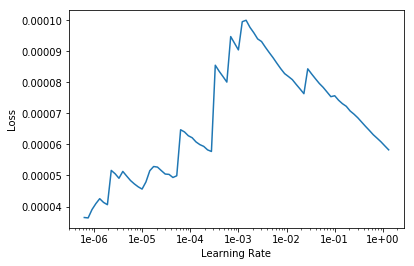

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.unfreeze()
learn.fit(20, 5e-2)

epoch,train_loss,valid_loss,accuracy
1,0.054859,2.909407,0.755556
2,0.599684,0.749195,0.800000
3,0.485574,0.536086,0.788889
4,0.370496,0.629404,0.788889
5,0.271454,0.724041,0.800000
6,0.196478,0.708017,0.788889
7,0.145375,0.755915,0.800000
8,0.109064,0.780443,0.788889
9,0.082642,0.802250,0.777778
10,0.063151,0.820663,0.788889


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


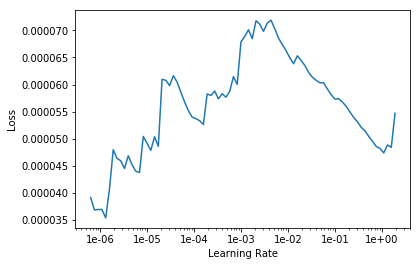

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
#from IPython.core.debugger import set_trace
#set_trace()
#learn.fit_one_cycle(20, max_lr=slice(1e-4, 1e-1))

In [40]:
#%debug

In [41]:
learn.unfreeze()
learn.fit(20, 1e-1)

epoch,train_loss,valid_loss,accuracy
1,0.165378,3.839339,0.766667
2,0.462365,0.644368,0.800000
3,0.296834,0.596629,0.811111
4,0.213407,0.682681,0.855556
5,0.153589,0.671111,0.811111
6,0.110922,0.676950,0.811111
7,0.081911,0.751844,0.822222
8,0.061376,0.816528,0.855556
9,0.046644,0.824634,0.855556
10,0.035676,0.801368,0.811111


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


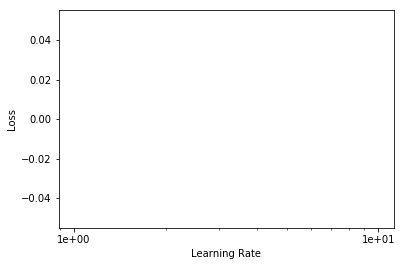

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.save('stage-1-lowtlhighvlacc81')

## Inference

In [87]:
row = testdf.iloc[30]
print(row)
p = learn.predict(row)
print(p)

PassengerId                             922
Pclass                                    2
Name           Louch, Mr. Charles Alexander
Sex                                    male
Age                                      50
SibSp                                     1
Parch                                     0
Ticket                           SC/AH 3085
Fare                                     26
Cabin                                   NaN
Embarked                                  S
Name: 30, dtype: object
(Category 0, tensor(0), tensor([0.5970, 0.4030]))


In [88]:
pn = p[1].numpy()
print(pn)

0


In [68]:
#learn.get_preds()

In [94]:
# Create results dataframe
rescolnames = ['PassengerId', 'Survived']
results = pd.DataFrame(columns=rescolnames)
print(results)

Empty DataFrame
Columns: [PassengerId, Survived]
Index: []


In [95]:
# Predict and populate results df
for index, row in testdf.iterrows():
    prediction = learn.predict(row)
    predval = prediction[1].numpy()
    passid = testdf.loc[index]['PassengerId']
    results = results.append({'PassengerId':passid, 'Survived':predval}, ignore_index=True)
#    if(index==1):
#        print(prediction, predval, passid)
#        print(row)

In [96]:
print(results)

    PassengerId Survived
0           892        0
1           893        1
2           894        0
3           895        0
4           896        1
5           897        0
6           898        1
7           899        1
8           900        1
9           901        0
10          902        0
11          903        0
12          904        1
13          905        0
14          906        1
15          907        1
16          908        0
17          909        0
18          910        1
19          911        1
20          912        1
21          913        0
22          914        1
23          915        0
24          916        1
25          917        0
26          918        1
27          919        0
28          920        0
29          921        0
..          ...      ...
388        1280        0
389        1281        0
390        1282        0
391        1283        1
392        1284        0
393        1285        0
394        1286        0
395        1287        1


In [98]:
# move results to csv file to submit on Kaggle
resultsfile = results.to_csv(path/'titanicresultsv1.csv', index=False)

In [ ]:
# This is it. First iteration done!